In [62]:
from lineage_motif.plot import *
from lineage_motif.resample import *
import numba

In [63]:
@numba.njit
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [64]:
def simulate_tree(transition_matrix, labels='aAbBcCdD'):
    '''Simulate tree based on provided transition matrix and progenitor/cell type labels.
    Progenitors are represented by lowercase letters, cell types are represented by uppercase letters.
    
    Args:
        transition_matrix (array): matrix where rows represent original state, column represents state to transition into.
            Rows should sum to 1 for progenitors.
        labels (string): string with progenitor/cell type labels that correspond to the rows of the provided transition matrix.
    
    Returns:
        tree_input (string): new tree in NEWICK format after simulated division until no progenitor cells remaining.
    '''
    tree_input = 'a'
    # continue dividing if tree contains progenitors
    while re.findall('[a-z]', tree_input) != []: 
        tree_input = divide(tree_input, transition_matrix, labels)
    return tree_input

In [65]:
def divide(tree_input, transition_matrix, labels):
    '''Simulates a division in all progenitor cells
    
    Args:
        tree_input (string): tree in NEWICK format
        transition_matrix (array): matrix where rows represent original state, column represents state to transition into.
            Rows should sum to 1 for progenitors.
        labels (string): string with progenitor/cell type labels that correspond to the rows of the provided transition matrix.
    
    Returns:
        tree_input (string): new tree in NEWICK format after simulated division
    '''
    for i in re.findall('[a-z]', tree_input):
        i_escape = re.escape(i)
        i_escape_index = list(labels).index(i_escape)
        transition_probs = transition_matrix[i_escape_index]
        #print(i_escape, i_escape_index, transition_probs)
        
        # substitute the first match with a branch. count=1 ensures that only one progenitor is replaced
        tree_input = re.sub(i_escape, branch(transition_probs, labels), tree_input, count=1)
    return tree_input

In [66]:
def branch(transition_probs, labels):
    '''
    Generates a branch with two cells whose identity are chosen using provided `transition_probs`.
    
    Args:
        transition_probs (array): probabilities of generating the progenitors or cell fates indexed as in `labels`.
        labels (string): string with progenitor/cell type labels.
    
    Returns:
        branch_input: string of newly drawn branch. Should have the form (x,x)
    '''
    cell_1 = labels[sample_discrete(transition_probs)]
    cell_2 = labels[sample_discrete(transition_probs)]
    branch_input = f'({cell_1},{cell_2})'
    return branch_input

In [67]:
transition_matrix = np.array([[0.2, 0.525, 0.275, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0.2, 0.55, 0.25, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0.2, 0.575, 0.225, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0.2, 0.8],
                              [0, 0, 0, 0, 0, 0, 0, 0]])

In [68]:
all_trees_unsorted = [simulate_tree(transition_matrix, labels='aAbBcCdD') for i in range(1000)]
all_trees_unsorted[:10]

['(((A,A),(A,A)),((C,C),((C,C),B)))',
 '((A,A),A)',
 '((((C,((D,D),(C,C))),((D,((D,D),D)),(D,D))),(B,(((D,D),(D,D)),(D,D)))),A)',
 '(A,(B,B))',
 '(((B,(B,(C,C))),A),((((C,C),(C,C)),B),A))',
 '(A,(((C,C),B),A))',
 '(A,((C,(((D,D),C),C)),(((((((D,D),D),D),C),(C,C)),B),((B,(C,C)),(C,(D,D))))))',
 '(A,A)',
 '((A,((A,(B,(C,(((D,D),D),D)))),((((C,C),C),B),B))),A)',
 '(A,((B,B),B))']

In [69]:
all_trees_sorted = [sort_align_tree(i) for i in all_trees_unsorted]
all_trees_sorted[:10]

['(((A,A),(A,A)),((C,C),(B,(C,C))))',
 '(A,(A,A))',
 '((((C,((C,C),(D,D))),((D,(D,(D,D))),(D,D))),(B,(((D,D),(D,D)),(D,D)))),A)',
 '(A,(B,B))',
 '(((B,(B,(C,C))),A),((((C,C),(C,C)),B),A))',
 '(A,(A,(B,(C,C))))',
 '(A,((C,(C,(C,(D,D)))),(((((D,(D,(D,D))),C),(C,C)),B),((B,(C,C)),(C,(D,D))))))',
 '(A,A)',
 '((A,((A,(B,(C,(D,(D,(D,D)))))),((B,(C,(C,C))),B))),A)',
 '(A,(B,(B,B)))']

In [70]:
(doublet_dict, 
 cell_fates, 
 dfs_c) = resample_trees_doublets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto'
                                           )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [71]:
all_cells = make_df_all_cells(all_trees_sorted, make_cell_dict(cell_fates), 'observed', True)
all_cells/all_cells.sum()

,observed
A,0.266026
C,0.236874
B,0.263584
D,0.233516


In [72]:
cell_color_dict = make_color_dict(cell_fates, ['#F89A3A', 
                                                    '#9C80B8', 
                                                    '#F071AB', 
                                                    '#7EC352', 
                                                   ])

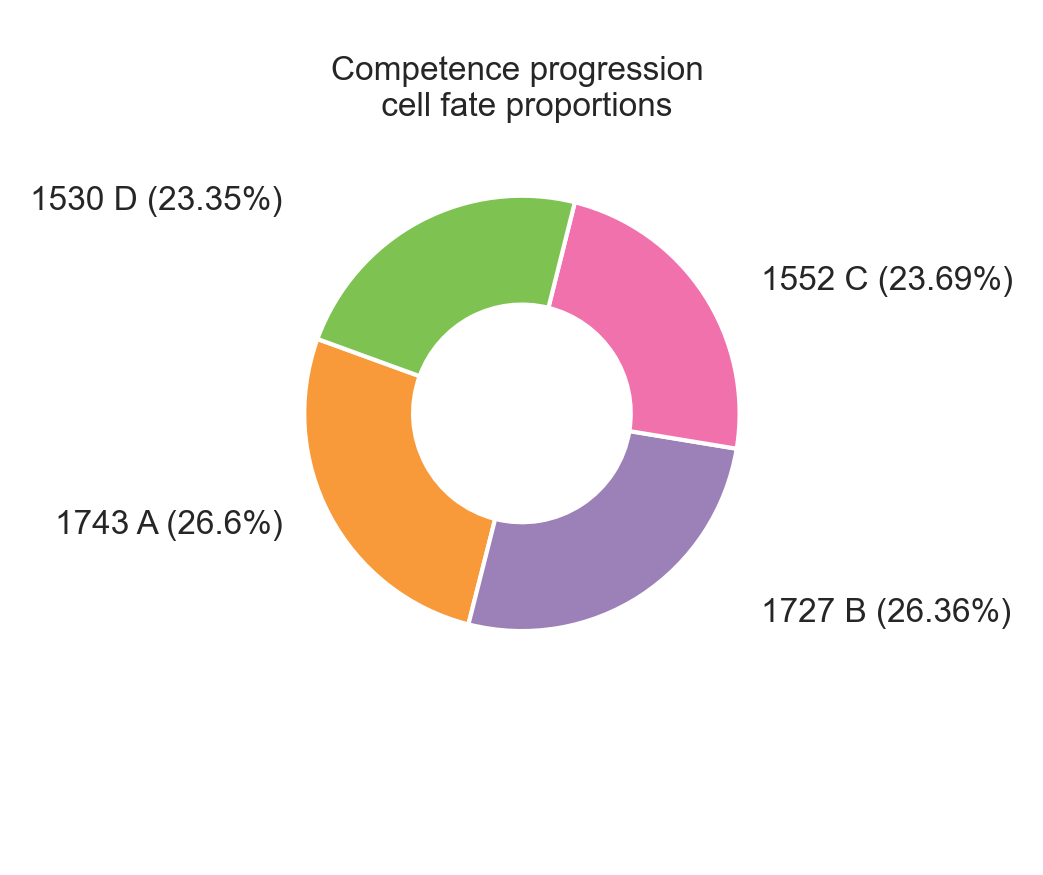

In [88]:
fig, ax = pyplot.subplots(1, 1, figsize=(3.25,3))
i=0

dict_all_cells_true = all_cells.sort_index()['observed'].to_dict()
cells = np.array([k for k, v in dict_all_cells_true.items()])
cell_counts = np.array([v for k, v in dict_all_cells_true.items()])
norm_cell_counts = np.round(cell_counts/cell_counts.sum()*100, 2)

norm_cell_counts_str = [f' ('+str(percent)+'%)' for ind, percent in enumerate(norm_cell_counts)]
annot = [str(count)+' '+cell+suffix for count, cell, suffix in zip(cell_counts, cells, norm_cell_counts_str)]

data = dict_all_cells_true.values()

colors_to_use = cell_color_dict.values()
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-200, colors=colors_to_use, )

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for b, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(annot[b], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                horizontalalignment=horizontalalignment, **kw, **{'fontname':'Arial', 'size':8})

ax.set_title(f"Competence progression \n cell fate proportions", y=1, **{'fontname':'Arial', 'size':8})

pyplot.tight_layout(h_pad=-8, w_pad=4)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.grid(False)
#pyplot.title("Cell fate proportions across zebrafish retina regions", y=0, **{'fontname':'Arial', 'size':8}, fontweight="bold")

image_format = 'svg'

pyplot.savefig(f"comp_prog_cell_fate_proportions.{image_format}", dpi=300, bbox_inches="tight")

In [74]:
(df_true_melt_subset, 
 df_melt_subset, 
 df_melt_100resamples_subset, 
 df_null_zscores_i_c_melt_subset, 
 df_null_zscores_i_c_melt_100resamples_subset) = dfs_for_plotting(dfs_c, 
                                                                       1000, 
                                                                       doublet_dict, 
                                                                       cutoff=None, 
                                                                       num_null=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

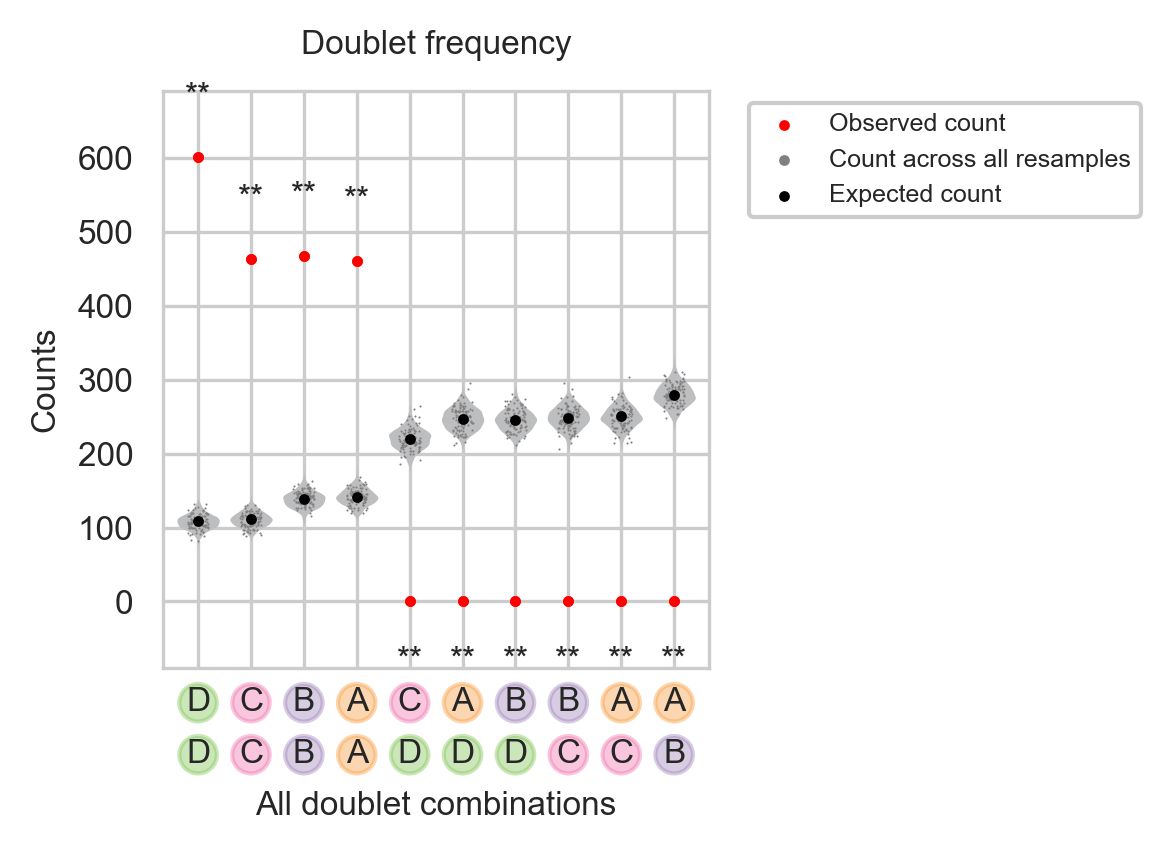

In [75]:
plot_frequency('doublet', 
                    df_true_melt_subset, 
                    df_melt_subset, 
                    df_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=None, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

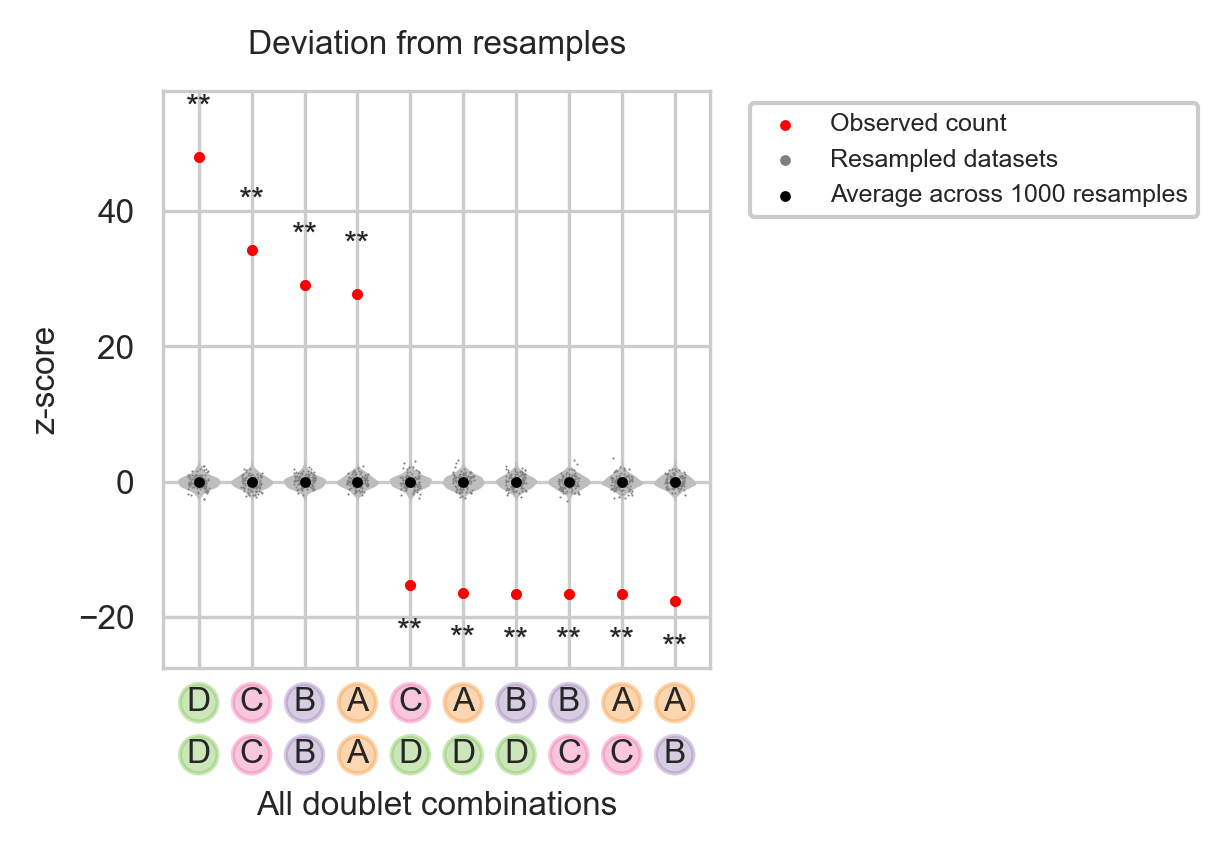

In [76]:
plot_deviation('doublet', 
                    df_true_melt_subset, 
                    df_null_zscores_i_c_melt_subset, 
                    df_null_zscores_i_c_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=None, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=1000,
                    legend_bool=True,
                    legend_pos='outside',
                    save=True, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_doublet')

In [77]:
(triplet_dict, 
 cell_fates, 
 dfs_c) = resample_trees_triplets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto'
                                           )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [78]:
(df_true_melt_subset, 
 df_melt_subset, 
 df_melt_100resamples_subset, 
 df_null_zscores_i_c_melt_subset, 
 df_null_zscores_i_c_melt_100resamples_subset) = dfs_for_plotting(dfs_c, 
                                                                       1000, 
                                                                       triplet_dict, 
                                                                       cutoff=15, 
                                                                       num_null=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

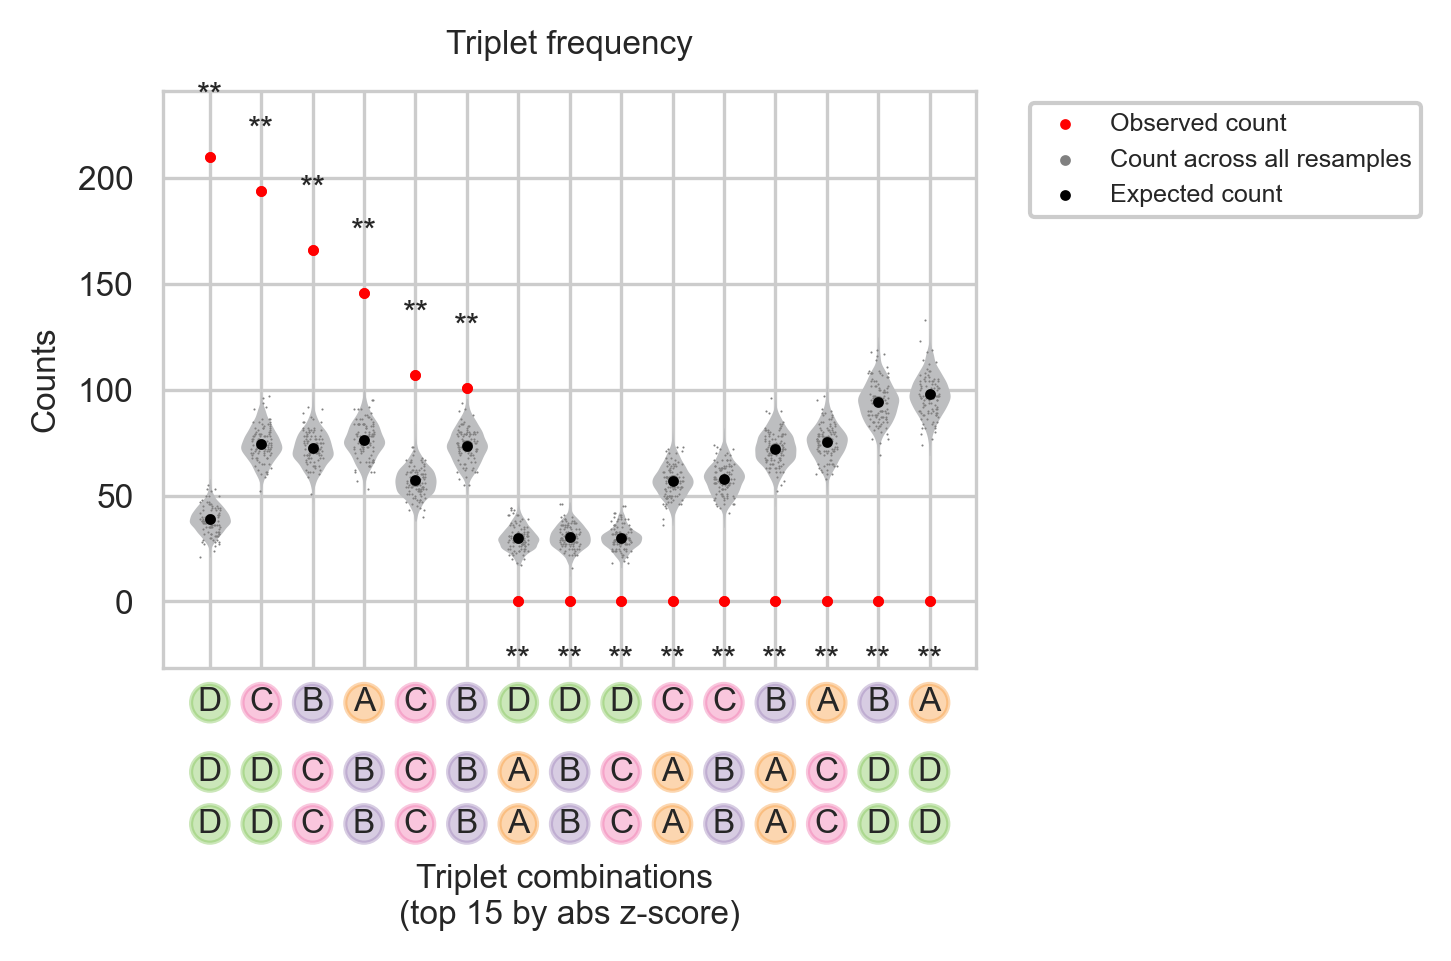

In [79]:
plot_frequency('triplet', 
                    df_true_melt_subset, 
                    df_melt_subset, 
                    df_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=15, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

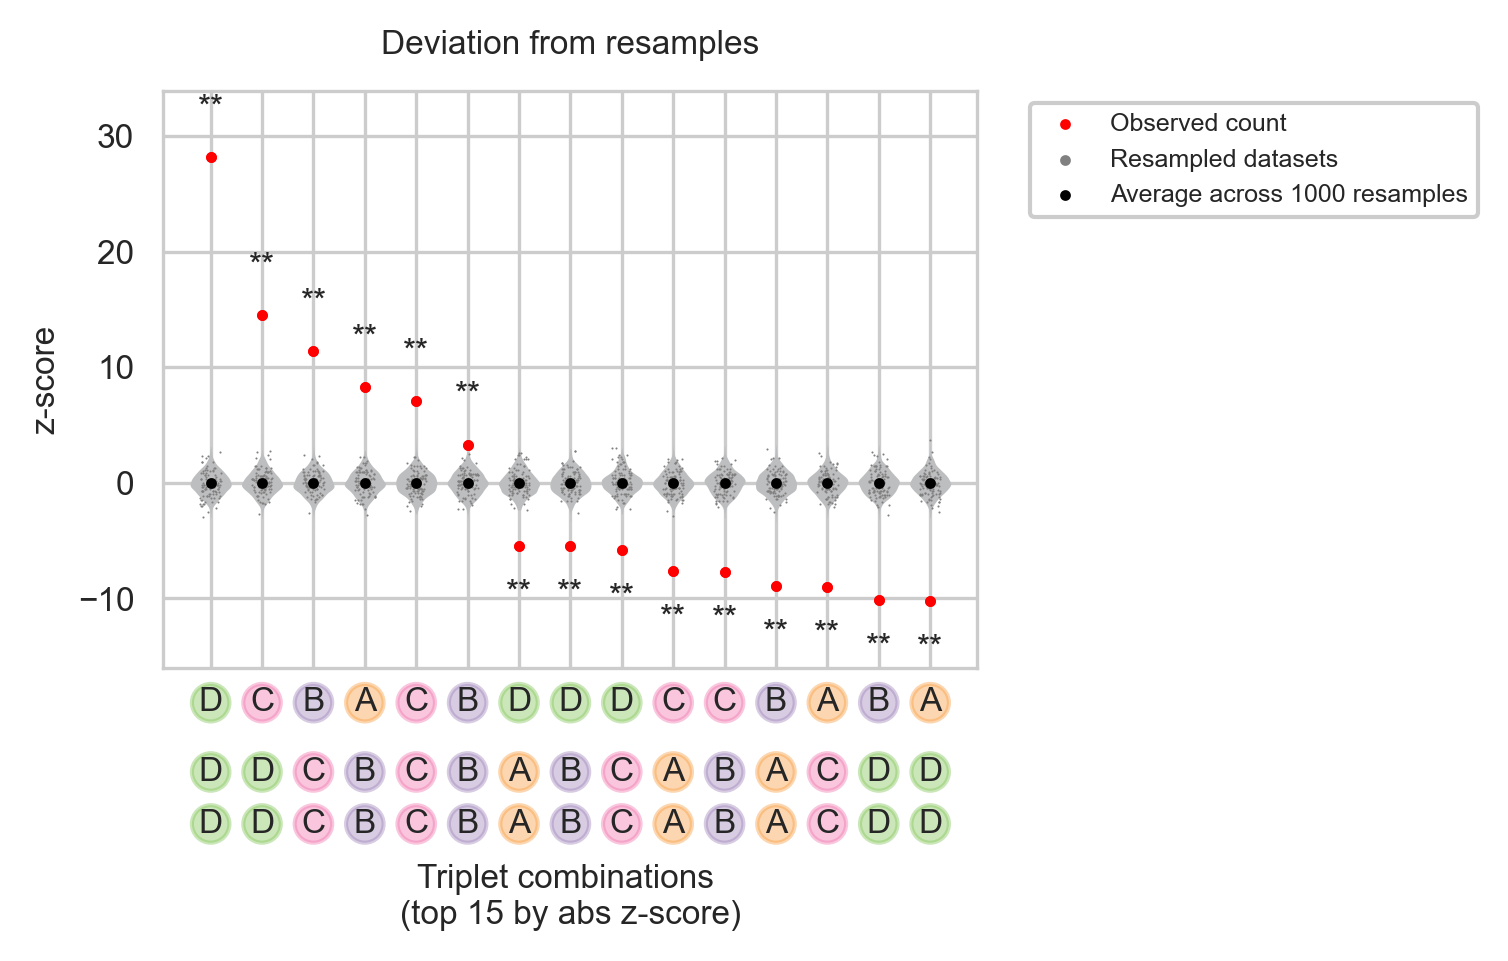

In [80]:
plot_deviation('triplet', 
                    df_true_melt_subset, 
                    df_null_zscores_i_c_melt_subset, 
                    df_null_zscores_i_c_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=15, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=1000,
                    legend_bool=True,
                    legend_pos='outside',
                    save=True, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_triplet')

In [81]:
(asym_quartet_dict, 
 cell_fates, 
 dfs_c) = resample_trees_asym_quartets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto'
                                           )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [85]:
(df_true_melt_subset, 
 df_melt_subset, 
 df_melt_100resamples_subset, 
 df_null_zscores_i_c_melt_subset, 
 df_null_zscores_i_c_melt_100resamples_subset) = dfs_for_plotting(dfs_c, 
                                                                       1000, 
                                                                       asym_quartet_dict, 
                                                                       cutoff=25, 
                                                                       num_null=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

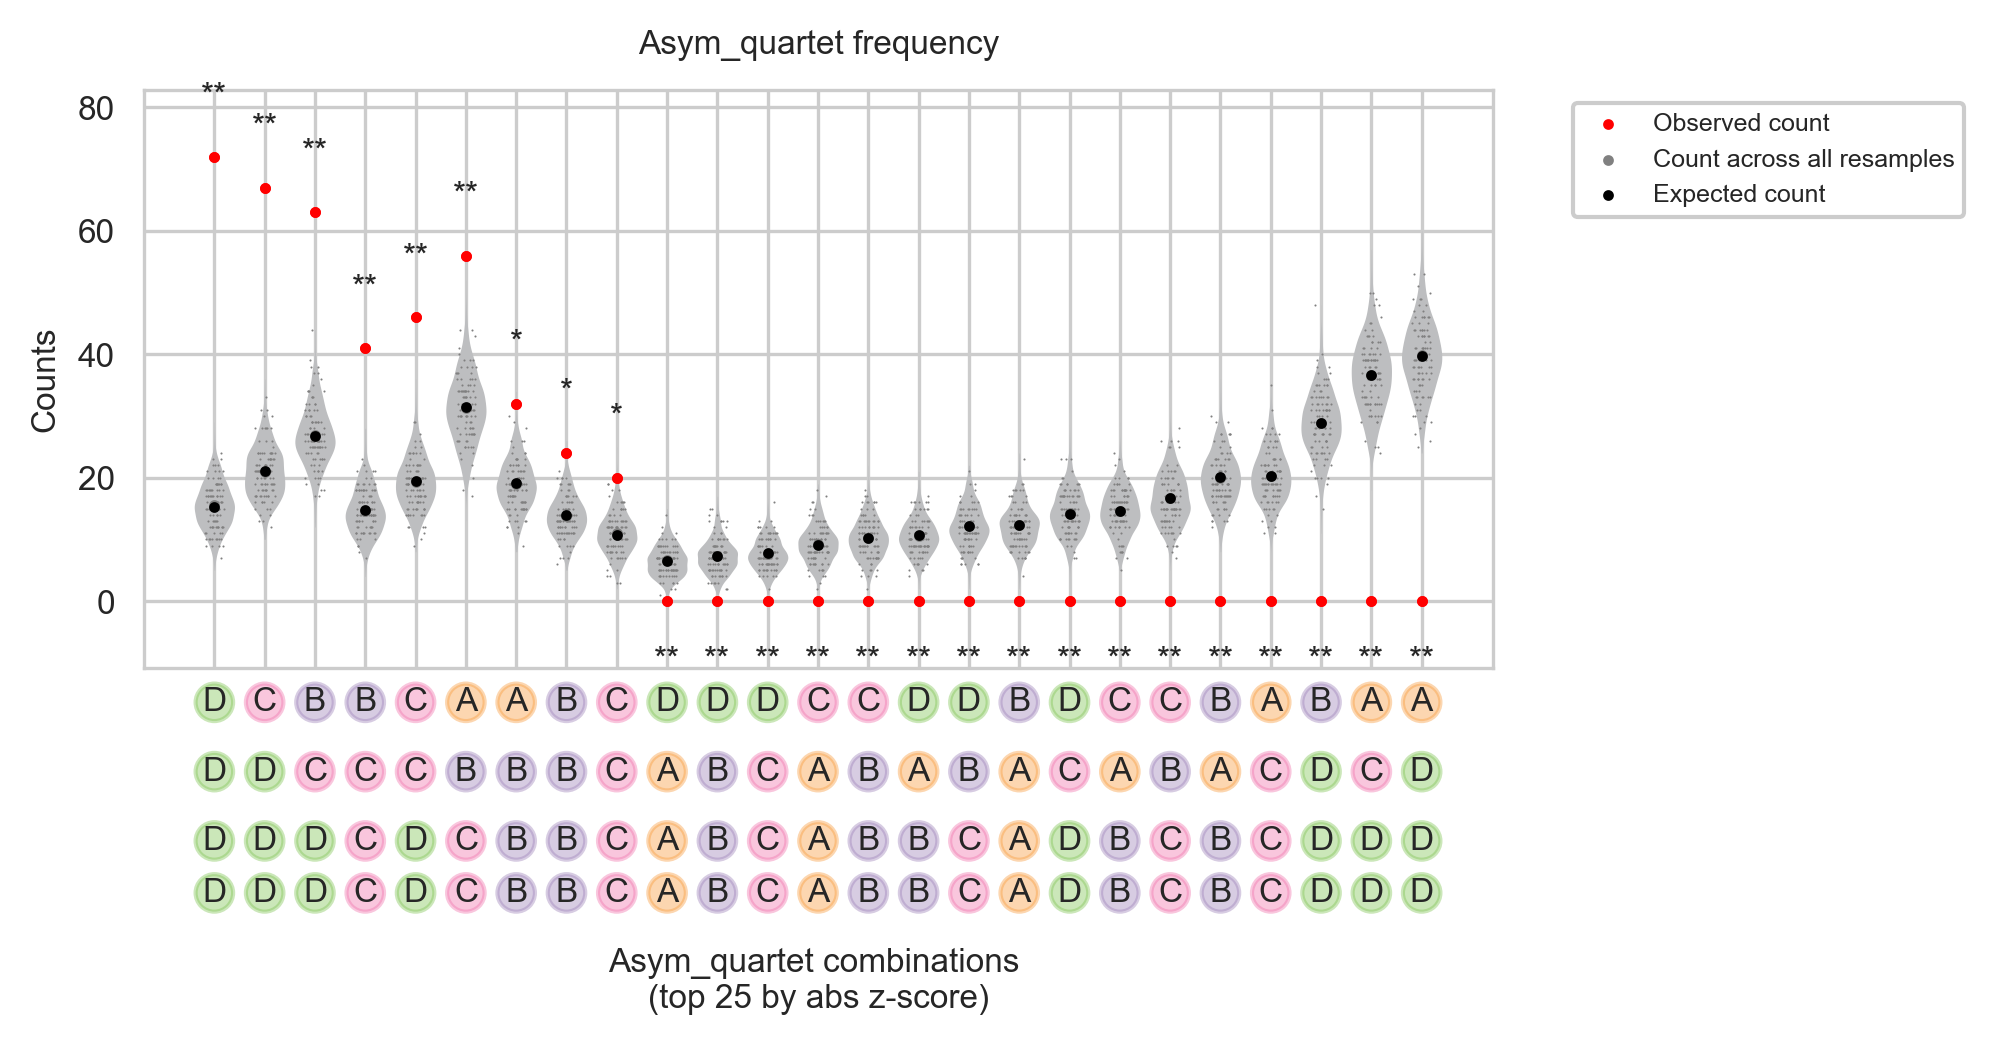

In [86]:
plot_frequency('asym_quartet', 
                    df_true_melt_subset, 
                    df_melt_subset, 
                    df_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

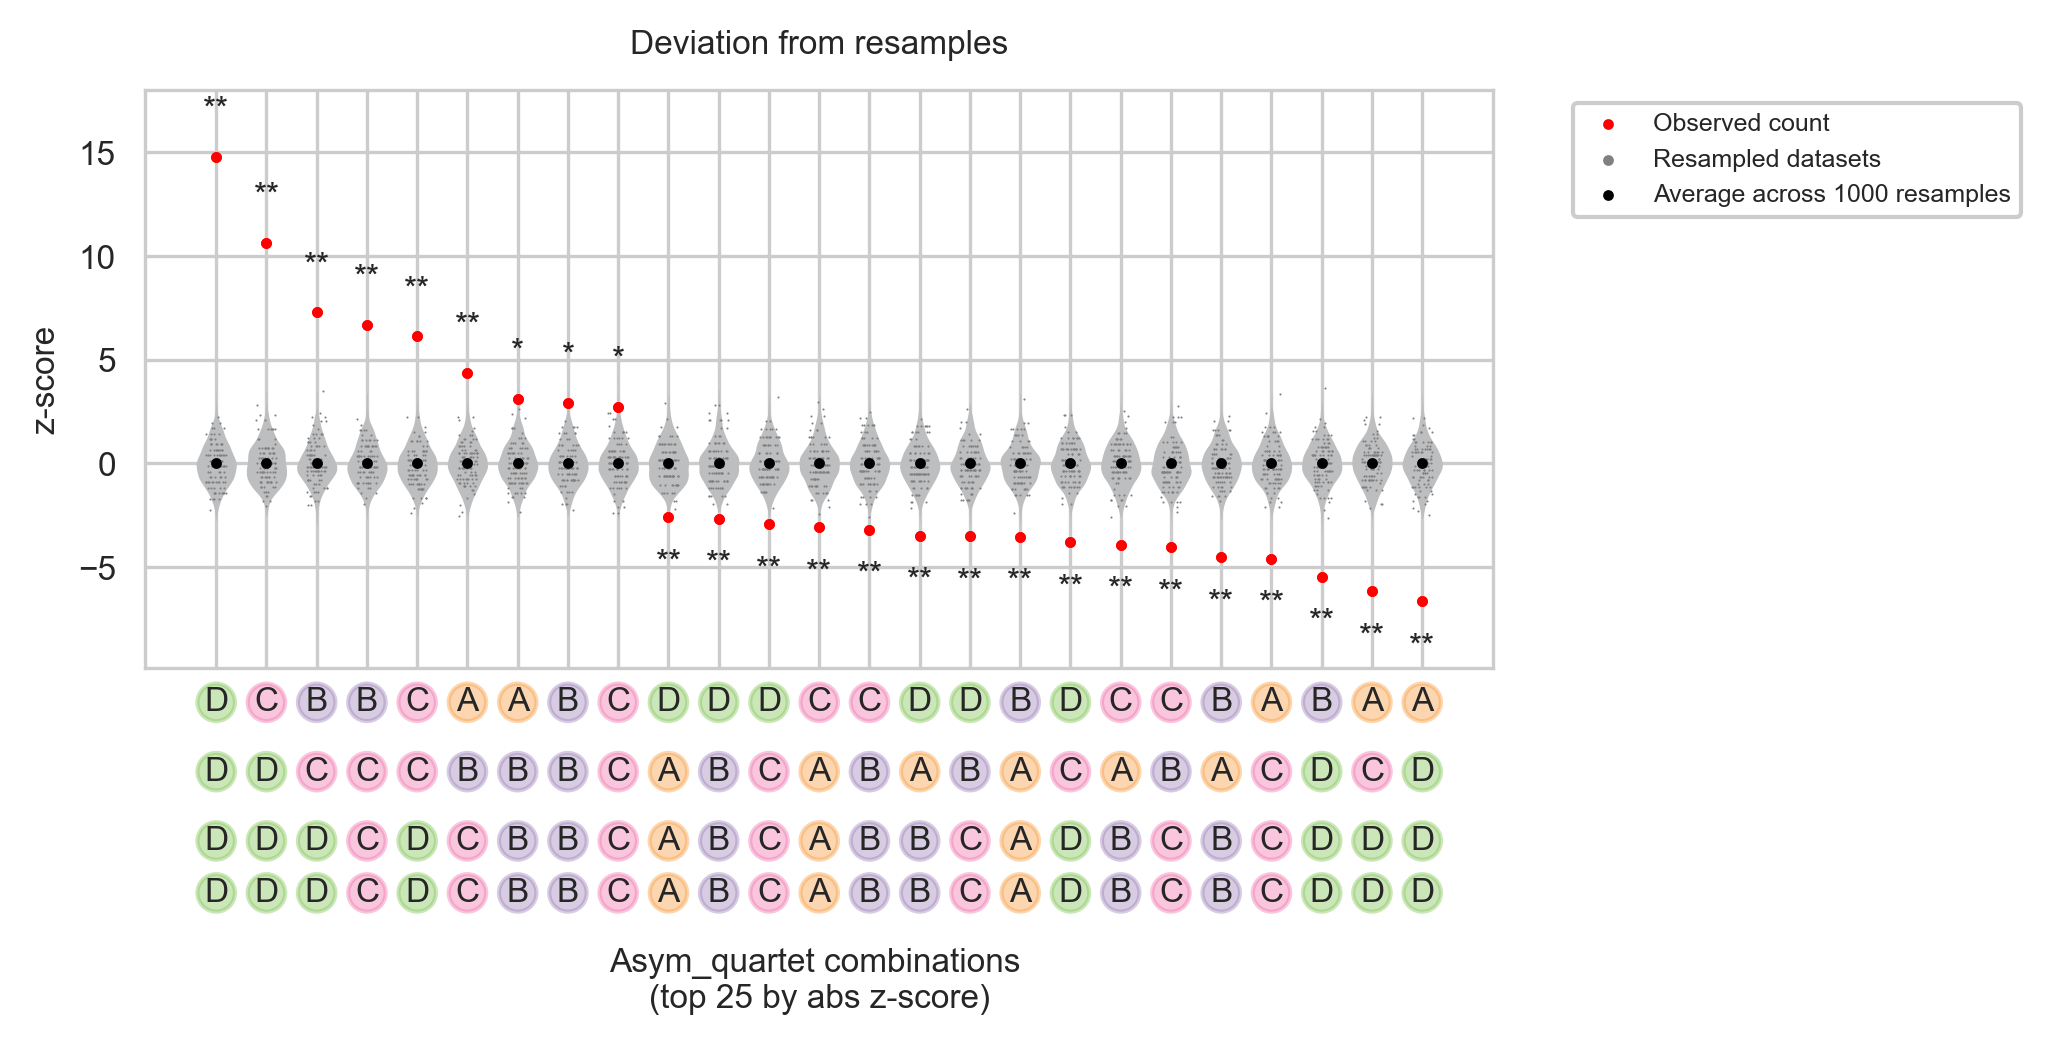

In [87]:
plot_deviation('asym_quartet', 
                    df_true_melt_subset, 
                    df_null_zscores_i_c_melt_subset, 
                    df_null_zscores_i_c_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=1000,
                    legend_bool=True,
                    legend_pos='outside',
                    save=True, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_asym_quartet')